In [1]:
!pip install tensorflow==2.20.0
!pip install scikit-learn numpy pandas opencv-python matplotlib seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 137.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is in

In [2]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/archive (38).zip"
extract_path = "/content/cardiomegaly-disease-prediction-using-cnn"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data extracted successfully!")

Mounted at /content/drive
Data extracted successfully!


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

class_names=['false','true']
label_of_classes={class_name:i for i,class_name in enumerate(class_names)}
n_classes=len(class_names)
image_size=(128,128)

In [4]:
def load_data():
    data_sets = [
        '/content/cardiomegaly-disease-prediction-using-cnn/train/train',
        '/content/cardiomegaly-disease-prediction-using-cnn/test/test'
    ]
    output = []

    for dataset in data_sets:
        images = []
        labels = []

        for folder in os.listdir(dataset):
            folder_path = os.path.join(dataset, folder)

            if not os.path.isdir(folder_path):
                continue

            label = label_of_classes[folder]

            for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder } in {dataset.split('/')[-1]}"):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"⚠️ image not found: {img_path}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, image_size)

                images.append(img)
                labels.append(label)
            print(f"number of {folder } in {dataset.split('/')[-1]}  is {len(os.listdir(folder_path))}")
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))

    return output

In [5]:
(train_images,train_labels),(test_images,test_labels)=load_data()


train_labels = train_labels.squeeze()
test_labels  = test_labels.squeeze()
train_images,train_labels =shuffle(train_images,train_labels,random_state=42)
print(f"numper of traning ex : {train_labels.shape[0]} \nnumper of test ex : {test_labels.shape[0]}")


Loading true in train: 100%|██████████| 2219/2219 [00:00<00:00, 2392.42it/s]


number of true in train  is 2219


Loading false in train: 100%|██████████| 2219/2219 [00:00<00:00, 2304.46it/s]


number of false in train  is 2219


Loading true in test: 100%|██████████| 557/557 [00:00<00:00, 3744.13it/s]


number of true in test  is 557


Loading false in test: 100%|██████████| 557/557 [00:00<00:00, 3850.41it/s]


number of false in test  is 557
numper of traning ex : 4438 
numper of test ex : 1114


In [6]:
train_images=train_images/255.0
test_images=test_images/255.0


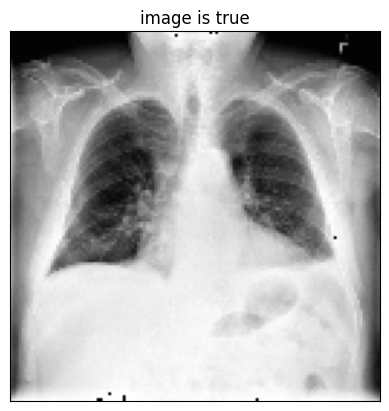

In [ ]:
def display_images(class_names,images,labels):
    index=np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.title(f"image is {class_names[labels[index]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()
display_images(class_names,train_images,train_labels)

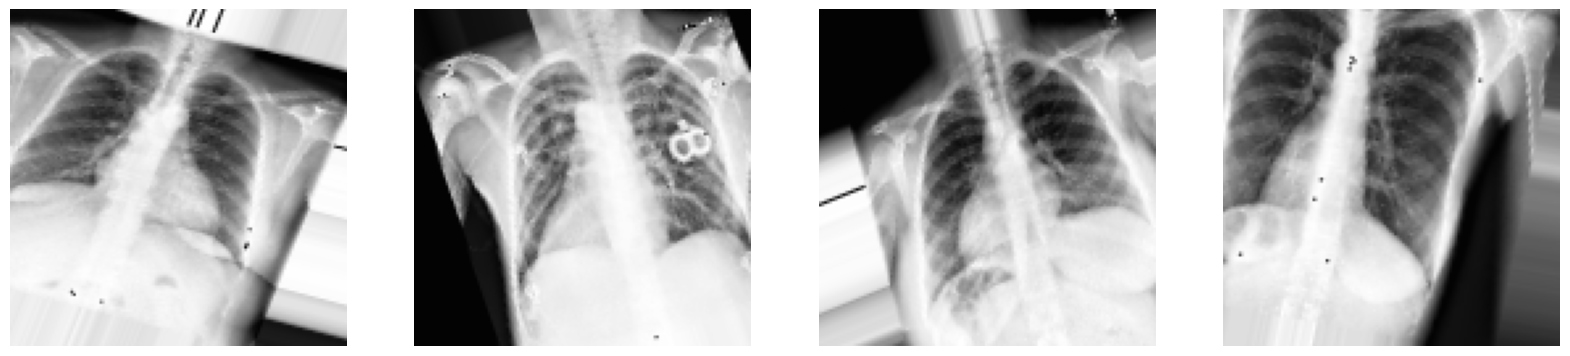

In [8]:
def plot (data_genrator,images):
    data_genrator.fit(images)
    etrator=data_genrator.flow(images)

    fig,axes=plt.subplots(1,4,figsize=(20,20))
    for ax in axes:
        batch=next(etrator)
        img=batch[0]
        ax.imshow(img)
        ax.axis('off')


data_genrator=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True

)
plot (data_genrator,train_images)

In [9]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    random_state=42
)

train_gen = data_genrator.flow(train_images, train_labels, batch_size=32)
val_gen   = data_genrator.flow(val_images, val_labels, batch_size=32)


In [18]:
my_model=models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),


    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1,activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
my_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )
my_model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=1,
    callbacks=[EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )]
)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.4886 - loss: 0.6962

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 67s 591ms/step - accuracy: 0.4886 - loss: 0.6961 - val_accuracy: 0.5225 - val_loss: 0.6929
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 63s 569ms/step - accuracy: 0.5272 - loss: 0.6928 - val_accuracy: 0.5191 - val_loss: 0.6930
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 63s 562ms/step - accuracy: 0.5014 - loss: 0.6919 - val_accuracy: 0.5450 - val_loss: 0.6884
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 63s 567ms/step - accuracy: 0.5203 - loss: 0.6940 - val_accuracy: 0.5259 - val_loss: 0.6900
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 81s 559ms/step - accuracy: 0.5249 - loss: 0.6915 - val_accuracy: 0.5101 - val_loss: 0.6923
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 62s 559ms/step - accuracy: 0.5449 - loss: 0.6905 - val_accuracy: 0.5372 - val_loss: 0.6894


In [20]:
test_loss, test_acc = my_model.evaluate(test_images, test_labels, verbose=0)
train_loss,train_acc = my_model.evaluate(train_images,train_labels,verbose=0)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f"\n train accuracy : {train_acc*100:.2f}%")


 Test Accuracy: 51.53%

 train accuracy : 52.31%


In [21]:
my_model.save('xray_classfication_model.h5')
